In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib
#Importing Important libraries
import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
from haversine import haversine
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options

In [2]:
import os
# We initialise the function to read data as required.
# If we pass train.csv in dataSet, we get the training data and if we pass train.csv in dataSet, we get the testing data.
def loadData(dataSet):
    dataPath = os.path.join("data", "")
    csvPath = os.path.join(dataPath, dataSet)
    return pd.read_csv(csvPath)

In [3]:
trainingData = loadData("train.csv")
trainingData.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Mean trip duration is: 6.4645211752676754


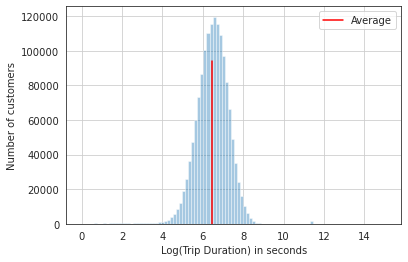

In [8]:
# Here we add a new column named log_trip_duration which is simply the log of trip duration in base 10.
# The plot below shows the log_trip_duration plotted against the number of customers
# As you can clearly see by the red line, the meanTrip duration (in log) is 6.46.
trainingData['log_trip_duration'] = np.log(trainingData['trip_duration'].values)
meanTripDuration = trainingData.log_trip_duration.mean()
print("Mean trip duration is: " + str(meanTripDuration))
with sns.axes_style("white"): 
    trainingData.log_trip_duration.hist(bins=100, alpha=0.4)
    plt.axvline(meanTripDuration, 0, 0.75, color="red", label="Average")
    plt.xlabel("Log(Trip Duration) in seconds")
    plt.ylabel("Number of customers")
    plt.legend()

In [9]:
# Lets check for null values in our data. If the data contains any null values, then while training these might cause error.
# Luckily, our data has no entries which are null and hence we don't need to clean it up.
trainingData.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
log_trip_duration     0
dtype: int64

In [10]:
# This is our training label column. Since we are using supervised learning for this assignment,
# the label will be what we will predict in our testing data.
# trainingLabel = trainingData.pop('trip_duration')

In [11]:
# We change the date time and drop time features in our data to type datetime to make it easier for us to manipulate it.
trainingData["pickup_datetime"] = pd.to_datetime(trainingData["pickup_datetime"])
trainingData["dropoff_datetime"] = pd.to_datetime(trainingData["dropoff_datetime"])

In [12]:
trainingData["weekday"] = trainingData.pickup_datetime.dt.day_name()
trainingData["weekdayNum"] = trainingData.pickup_datetime.dt.weekday
trainingData["month"] = trainingData.pickup_datetime.dt.month
trainingData["pickupHour"] = trainingData.pickup_datetime.dt.hour

In [13]:
trainingData.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,Monday,0,3,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.496775,Sunday,6,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661056,Tuesday,1,1,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.061457,Wednesday,2,4,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.075346,Saturday,5,3,13


In [14]:
# Distance function to get the distance between two places.
def distance(dataSet):
    pickuploc = (dataSet["pickup_latitude"], dataSet["pickup_longitude"])
    dropoffloc = (dataSet["dropoff_latitude"], dataSet["dropoff_longitude"])
    return haversine(pickuploc, dropoffloc)

In [15]:
# We add this distance to the training data as a new coloumn for every ride. 
# this will help up to make better predictions using more features
trainingData["distance"] = trainingData.apply(lambda x: distance(x) , axis = 1)

In [16]:
trainingData.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,Monday,0,3,17,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.496775,Sunday,6,6,0,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661056,Tuesday,1,1,11,6.385107
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.061457,Wednesday,2,4,19,1.485500
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.075346,Saturday,5,3,13,1.188590


In [17]:
trainingData.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [18]:
dummyValue = pd.get_dummies(trainingData.store_and_fwd_flag, prefix="flag")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

dummyValue = pd.get_dummies(trainingData.vendor_id, prefix="vendor_id")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

dummyValue = pd.get_dummies(trainingData.passenger_count, prefix="passenger_count")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

dummyValue = pd.get_dummies(trainingData.pickupHour, prefix="pickupHour")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

dummyValue = pd.get_dummies(trainingData.month, prefix="month")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

dummyValue = pd.get_dummies(trainingData.weekdayNum, prefix="weekdayNum")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

In [19]:
trainingData.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,Monday,0,3,17,1.498523,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.496775,Sunday,6,6,0,1.805510,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661056,Tuesday,1,1,11,6.385107,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.061457,Wednesday,2,4,19,1.485500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.075346,Saturday,5,3,13,1.188590,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [20]:
trainingData.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [21]:
trainingData.passenger_count.describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

In [22]:
# Since the average value of passenger is equal to 1 then lets change the values which are zero to 1 since having 0 
# 0 passenger in a taxi and doing a trip is physically impossible. Further more there are only 60 0 values
# in a data set of 1.4 million values so changing them won't have much effect.
trainingData["passenger_count"] = trainingData.passenger_count.map(lambda x: 1 if x == 0 else x)

In [23]:
trainingData.passenger_count.value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
7          3
9          1
8          1
Name: passenger_count, dtype: int64

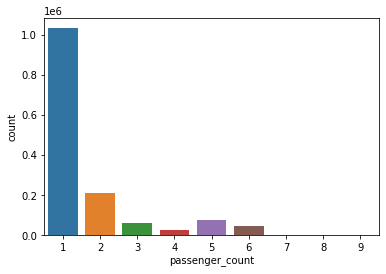

In [24]:
sns.countplot(trainingData.passenger_count)

In [25]:
# Lets see the trips which have more than 24 hrs of travelling time. Since there will be very few,
# it will be safe to remove them from the data as they are outliers and it won't be helpful to take
# them into consideration.
trainingData[trainingData.trip_duration >= 86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,14.478062,Tuesday,1,1,0,20.148692,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,14.533144,Saturday,5,2,22,5.982495,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,14.616441,Tuesday,1,1,6,1.635130,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,15.075755,Saturday,5,2,22,19.900689,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [26]:
trainingData = trainingData[trainingData.trip_duration <= 86400]

Text(0, 0.5, 'Trip Count')

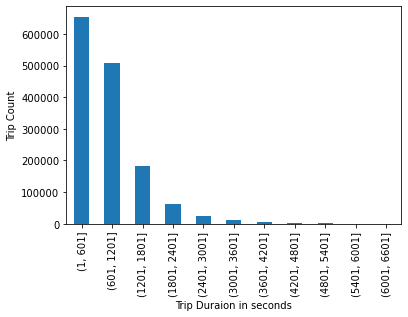

In [27]:
trainingData.trip_duration.groupby(pd.cut(trainingData.trip_duration, np.arange(1,7200,600))).count().plot(kind='bar')
plt.xlabel("Trip Duraion in seconds")
plt.ylabel("Trip Count")

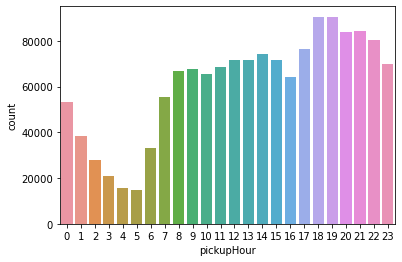

In [28]:
sns.countplot(trainingData.pickupHour)
# This a comlpletely natural plot. The number of pick ups per hour start to increase from 6 am
# as people start to head off to work. It is highest during eveing as people return, or go out for leisure.

In [29]:
trainingData[trainingData.pickup_longitude == trainingData.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6
1184454,id2854272,2,2016-02-26 13:50:19,2016-02-26 13:58:38,2,-121.933342,37.389381,-121.933304,37.389511,N,499,6.212606,Friday,4,2,13,0.014811,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [30]:
# as you see this location is clearly not i new york, but it is somewhere on the west coast. 
# This is an outlier which will cause inconsistency to our model and hence has to be removed
trainingData = trainingData[trainingData.pickup_longitude != trainingData.pickup_longitude.min()]

In [31]:
trainingData[trainingData.pickup_longitude == trainingData.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6
1068810,id3777240,2,2016-01-27 18:26:40,2016-01-27 18:45:05,2,-121.933235,37.389297,-121.933205,37.389103,N,1105,7.007601,Wednesday,2,1,18,0.0218,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [32]:
# Agin this data is not from new york and has to be removed
trainingData = trainingData[trainingData.pickup_longitude != trainingData.pickup_longitude.min()]

In [33]:
trainingData[trainingData.pickup_longitude == trainingData.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6
1359910,id3628988,1,2016-05-05 18:21:37,2016-05-05 18:30:45,1,-79.569733,41.586273,-80.355431,42.090183,N,548,6.306275,Thursday,3,5,18,85.884995,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [34]:
list(zip(range(0, len(trainingData.columns)), trainingData.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration'),
 (11, 'log_trip_duration'),
 (12, 'weekday'),
 (13, 'weekdayNum'),
 (14, 'month'),
 (15, 'pickupHour'),
 (16, 'distance'),
 (17, 'flag_Y'),
 (18, 'vendor_id_2'),
 (19, 'passenger_count_1'),
 (20, 'passenger_count_2'),
 (21, 'passenger_count_3'),
 (22, 'passenger_count_4'),
 (23, 'passenger_count_5'),
 (24, 'passenger_count_6'),
 (25, 'passenger_count_7'),
 (26, 'passenger_count_8'),
 (27, 'passenger_count_9'),
 (28, 'pickupHour_1'),
 (29, 'pickupHour_2'),
 (30, 'pickupHour_3'),
 (31, 'pickupHour_4'),
 (32, 'pickupHour_5'),
 (33, 'pickupHour_6'),
 (34, 'pickupHour_7'),
 (35, 'pickupHour_8'),
 (36, 'pickupHour_9'),
 (37, 'pickupHour_10'),
 (38, 'pickupHour_11'),
 (39, 'pickupHour_12'),
 (40, 'pickupHour_13'),
 (41, 'pickupHour_14

In [35]:
Y = trainingData.iloc[:,10].values
X = trainingData.iloc[:,range(16,61)].values
# We did the above to split the data into two np.ndarrray. Y contains the original data columns and
# X conatins the ones we made to help our model.

In [36]:
from sklearn.model_selection import train_test_split
# Lets split the training testing data. 20% data will  for testing and rest for training.
testSplit = 0.2
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, random_state=4, test_size=testSplit)
# Here Xtrain is our training data with Ytrain being the training labels.
# Xtest is testing data with Ytest being the testing predictions.

In [37]:
from sklearn.linear_model import LinearRegression
modelLinearRegression = LinearRegression()
modelLinearRegression.fit(Xtrain, Ytrain)

LinearRegression()

In [38]:
Ypred = modelLinearRegression.predict(Xtest)

In [39]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(Ytest, Ypred))

3216.5281919718163

In [40]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Ytest, Ypred)

450.03152882755563

In [41]:
from sklearn.ensemble import RandomForestRegressor
modelRandomForestRegressor = RandomForestRegressor(n_jobs=-1, verbose=3)
modelRandomForestRegressor.fit(Xtrain, Ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100building tree 3 of 100

building tree 4 of 100
building tree 5 of 100building tree 6 of 100building tree 7 of 100
building tree 8 of 100


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100building tree 43 of 100

building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.1min finished


RandomForestRegressor(n_jobs=-1, verbose=3)

In [42]:
YpredRFR = modelRandomForestRegressor.predict(Xtest)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   13.2s finished


In [43]:
mean_absolute_error(Ytest, YpredRFR)

489.99572681067946

In [44]:
np.sqrt(mean_squared_error(Ytest, YpredRFR))

3484.8789013738738

In [81]:
countNorm = 0
countRFR = 0
for i in range(0,len(Ytest)):
    if Ytest[i] - YpredRFR[i] <= 10:
        countRFR += 1
    if Ytest[i] - Ypred[i] <= 10:
        countNorm += 1


In [82]:
countRFR / len(Ytest)

0.5939916634673394

In [83]:
countNorm / len(Ytest)

0.7046632479570011

In [84]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)

In [90]:
import statsmodels.api as sm
XOpt = X1[:,range(0,46)]
regressorOLS = sm.OLS(endog=Y, exog = XOpt).fit()

In [91]:
pvals = regressorOLS.pvalues
significanceLvl = 0.05

In [93]:
while max(pvals) > significanceLvl:
    print("Probability values of each feature \n")
    print(pvals)
    XOpt = np.delete(XOpt, np.argmax(pvals), axis = 1)
    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(pvals))))
    print(str(XOpt.shape[1]-1) + " dimensions remaining now... \n")
    regressorOLS = sm.OLS(endog = Y, exog = XOpt).fit()
    pvals = regressorOLS.pvalues
    print("=================================================================\n")
    
#Print final summary
print("Final stat summary with optimal {} features".format(str(XOpt.shape[1]-1)))
regressorOLS.summary()

Probability values of each feature 

[1.08763780e-03 0.00000000e+00 9.62558760e-02 0.00000000e+00
 5.66609198e-03 6.77326588e-03 8.69213104e-03 1.03485578e-02
 6.57450334e-03 6.64210563e-03 3.45792817e-01 4.74712546e-01
 6.74609011e-01 4.03607368e-01 3.53162896e-01 9.78477051e-01
 3.24899635e-02 1.17938962e-15 3.48153880e-18 4.78716436e-01
 1.86433230e-11 1.50038039e-15 2.63739884e-14 9.92098575e-20
 1.52567766e-27 8.46375062e-33 1.18244845e-41 7.89869422e-57
 1.22861524e-37 8.83361636e-31 2.19188779e-24 8.53966874e-07
 8.32285733e-02 2.18234892e-01 1.23911478e-04 5.97047498e-01
 8.02411425e-01 2.77488519e-03 5.03126465e-10 3.46345679e-20
 1.56437304e-25 2.69204125e-29 1.11333530e-39 6.69812170e-60
 1.48516694e-54 5.00046196e-14]


Feature at index 15 is removed 

43 dimensions remaining now... 


Probability values of each feature 

[1.19863536e-03 0.00000000e+00 9.59677386e-02 0.00000000e+00
 5.69312900e-03 6.81040462e-03 8.73367126e-03 1.03958738e-02
 6.60366691e-03 6.66777907e-03 3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1172.
Date:                Fri, 24 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:20:07   Log-Likelihood:            -1.3810e+07
No. Observations:             1458638   AIC:                         2.762e+07
Df Residuals:                 1458604   BIC:                         2.762e+07
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1195.7494    388.312      3.079      0.002     434.672    1956.827
x1           113.6046      0.606    187.387      0.000     112.416     114.793
x2           214.7024      5.445     39.433      0.000     204.031     225.374
x3          -985.6523    388.271     -2.539      0.011   -1746.650    -224.654
x4          -961.5822    388.319     -2.476      0.013   -1722.674    -200.491
x5          -928.1157    388.469     -2.389      0.017   -1689.502    -166.729
x6          -904.3247    388.703     -2.327      0.020   -1666.169    -142.481
x7          -966.2365    388.429     -2.488      0.013   -1727.544    -204.929
x8          -965.3196    388.528     -2.485      0.013   -1726.822    -203.818
x9          -237.3282     26.098     -9.094      0.000    -288.480    -186.177
x10         -196.1674     17.963    -10.920      0.000    -231.375    -160.960
x11          117.0335     13.197      8.868      0.000      91.168     142.898
x12          139.6082     13.131     10.632      0.000     113.872     165.344
x13          133.8809     13.304     10.064      0.000     107.806     159.955
x14          159.2140     13.047     12.203      0.000     133.642     184.786
x15          189.4809     12.784     14.822      0.000     164.425     214.536
x16          208.5841     12.809     16.284      0.000     183.478     233.690
x17          235.2173     12.604     18.662      0.000     210.514     259.921
x18          279.3035     12.783     21.849      0.000     254.249     304.358
x19          230.0102     13.390     17.178      0.000     203.766     256.254
x20          198.6446     12.455     15.948      0.000     174.232     223.057
x21          169.0447     11.632     14.533      0.000     146.247     191.842
x22           78.8785     11.646      6.773      0.000      56.052     101.705
x23           24.5916     11.986      2.052      0.040       1.100      48.083
x24           61.7147     12.196      5.060      0.000      37.811      85.619
x25           25.6930      7.702      3.336      0.001      10.597      40.789
x26           55.0618      7.743      7.111      0.000      39.886      70.237
x27           82.2501      7.777     10.576      0.000      67.007      97.493
x28           94.9254      7.932     11.967      0.000      79.378     110.473
x29           97.2925      8.617     11.290      0.000      80.403     114.182
x30          112.9128      8.523     13.248      0.000      96.208     129.618
x31          138.0756      8.414     16.410      0.000     121.584     154.567
x32          130.1087      8.348     15.586      0.000     113.748     146.470
x33           63.5692      8.386      7.581      0.000      47.134      80.005
==============================================================================
Omnibus:                  3543540.762   Durbin-Watson:                   2.000
Pr

In [94]:
Xtrainfs, Xtestfs, Ytrainfs, Ytestfs = train_test_split(XOpt, Y, random_state=4, test_size=0.2)